In [14]:
# Core
import numpy as np
import random
import json
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# COCO
import labelme2coco
from pycocotools.coco import COCO

# Detectron2 Visualization
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer

# Detectron2 Training
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo

# Detectron2 Inference
from detectron2.engine import DefaultPredictor

In [15]:
THRESHOLD = 0.5
MAX_ITER = 1000

# Clean up and aggregate annotations

In [16]:
# Path to the JSON file generated by labelme2coco
annotation_dir = "../data/annotations"
image_dir = "../data/images"

Ensure image names are all up to date

In [17]:
# Iterate over Labelme JSON files
for json_file in os.listdir(annotation_dir):
    if json_file.endswith(".json"):
        json_path = os.path.join(annotation_dir, json_file)

        # Load the JSON file
        with open(json_path, "r") as f:
            data = json.load(f)

        # Update the imagePath field
        image_name = os.path.splitext(json_file)[0] + ".png"  # Assuming images are PNGs
        data["imagePath"] = os.path.join(image_dir, image_name)

        # Save the updated JSON
        with open(json_path, "w") as f:
            json.dump(data, f, indent=4)

print("Updated all Labelme JSON files.")

Updated all Labelme JSON files.


Convert to aggregated coco format

In [18]:
# Ensure previous aggregated files are removed
files_to_delete = [f for f in os.listdir(annotation_dir) if '_' not in f]
for f in files_to_delete:
    os.remove(os.path.join(annotation_dir, f))

# annotation_file = f"{annotation_dir}/dataset.json"
# if os.path.exists(annotation_file):
#     os.remove(annotation_file)

# annotation_file_clean = f"{annotation_dir}/dataset_clean.json"
# if os.path.exists(annotation_file_clean):
#     os.remove(annotation_file_clean)

# Convert Labelme annotations to COCO
labelme2coco.convert(annotation_dir, annotation_dir)

There are 53 listed files in folder ../data/annotations.


Converting labelme annotations to COCO format: 100%|██████████| 53/53 [00:00<00:00, 154.26it/s]
12/02/2024 09:48:44 - INFO - labelme2coco -   Converted annotations in COCO format is exported to ..\data\annotations\dataset.json


Correct file_name attribute in aggregated json

In [19]:
annotation_file = f"{annotation_dir}/dataset.json"

# Open the COCO annotations file
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Fix file_name values
for image in coco_data['images']:
    image['file_name'] = os.path.basename(image['file_name'])

# Save the fixed annotations
with open(annotation_file, 'w') as f:
    json.dump(coco_data, f, indent=4)

print(f"Fixed annotations saved to {annotation_file}")

Fixed annotations saved to ../data/annotations/dataset.json


In [20]:
import copy

IMAGES_DIR = "../data/images"
ANNOTATIONS_DIR = "../data/annotations"

# Load COCO data and splits
with open("../data/annotations/dataset.json", "r") as f:
    coco_data = json.load(f)

with open("../data/split_mapping.json", "r") as f:
    splits = json.load(f)

class_names = [x['name'] for x in coco_data['categories']]

for split, images in splits.items():
    filtered_coco = copy.deepcopy(coco_data)
    # Filter images
    images = [img for img in coco_data['images'] if os.path.basename(img['file_name']) in images]
    image_ids = [img['id'] for img in images]
    # Filter annotations
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in image_ids]
    # Update coco and register
    filtered_coco['images'] = images
    filtered_coco['annotations'] = annotations
    # Save as json
    with open(f'../data/annotations/{split}.json', 'w') as f:
        json.dump(filtered_coco, f, indent=4)
    # Register
    annotations_file = os.path.join(ANNOTATIONS_DIR, f'{split}.json')
    register_coco_instances(split, {}, annotations_file, IMAGES_DIR)

In [21]:
filtered_coco

{'images': [{'height': 640,
   'width': 640,
   'id': 41,
   'file_name': '40.793456_-73.827023.png'}],
 'annotations': [{'iscrowd': 0,
   'image_id': 41,
   'bbox': [261.26984126984127,
    180.63492063492063,
    112.38095238095241,
    176.50793650793653],
   'segmentation': [[373, 184, 356, 357, 261, 350, 284, 180]],
   'category_id': 1,
   'id': 803,
   'area': 15930},
  {'iscrowd': 0,
   'image_id': 41,
   'bbox': [357.51879699248116,
    190.6015037593985,
    46.61654135338347,
    165.78947368421052],
   'segmentation': [[374, 194, 357, 356, 388, 340, 404, 204, 385, 190]],
   'category_id': 2,
   'id': 804,
   'area': 4647},
  {'iscrowd': 0,
   'image_id': 41,
   'bbox': [325.56390977443607,
    0.37593984962406013,
    10.5263157894737,
    127.44360902255639],
   'segmentation': [[330, 127, 336, 0, 330, 0, 325, 127]],
   'category_id': 6,
   'id': 805,
   'area': 692},
  {'iscrowd': 0,
   'image_id': 41,
   'bbox': [258.2706766917293,
    414.2857142857143,
    37.5939849624

# Prep COCO and Visualize

In [22]:
annotation_path = "../data/annotations/dataset.json"

# Load COCO annotations
with open(annotation_path, 'r') as f:
    coco_data = json.load(f)

coco = COCO(annotation_path)

# Generate color map for categories
categories = coco_data["categories"]

categories

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


[{'id': 0, 'name': 'lane', 'supercategory': 'lane'},
 {'id': 1, 'name': 'intersection', 'supercategory': 'intersection'},
 {'id': 2, 'name': 'crosswalk', 'supercategory': 'crosswalk'},
 {'id': 3, 'name': 'parkingLane', 'supercategory': 'parkingLane'},
 {'id': 4, 'name': 'overhead', 'supercategory': 'overhead'},
 {'id': 5, 'name': 'median', 'supercategory': 'median'},
 {'id': 6, 'name': 'doubleYellow', 'supercategory': 'doubleYellow'},
 {'id': 7, 'name': 'bikeLane', 'supercategory': 'bikeLane'},
 {'id': 8, 'name': 'overpass', 'supercategory': 'overpass'},
 {'id': 9, 'name': 'laneSeparator', 'supercategory': 'laneSeparator'},
 {'id': 10, 'name': 'busLane', 'supercategory': 'busLane'}]

In [23]:
image_path = "../data/images"
register_coco_instances("custom_train", {}, annotation_file, image_path)

# Verify dataset registration
metadata = MetadataCatalog.get("custom_train")
dataset_dicts = DatasetCatalog.get("custom_train")

12/02/2024 09:48:44 - WARNING - detectron2.data.datasets.coco -   
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

12/02/2024 09:48:44 - INFO - detectron2.data.datasets.coco -   Loaded 53 images in COCO format from ../data/annotations/dataset.json


In [24]:
color_map = {
    0: "orange",
    1: "blue",
    2: "green",
    3: "red",
    4: "purple",
    5: "yellow",
    6: "cyan",
    7: "magenta",
    8: "lime",
    9: "brown"
}

In [25]:
def visualize_annotations(coco, image_id, image_path):
    """
    Visualize COCO-style annotations on a sample image.
    
    :param coco: COCO object.
    :param image_id: ID of the image to visualize.
    """
    # Load image metadata
    img_info = coco.loadImgs(image_id)[0]
    img_file_path = f"{image_path}/{img_info['file_name']}"    

    # Load the image
    img = cv2.imread(img_file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get all annotations for the image
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)

    # Plot the image
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')

    # Overlay each annotation
    for ann in annotations:
        if 'segmentation' in ann:
            category_id = ann['category_id']
            color = color_map[category_id]  # Get color for the category
            segmentation = ann['segmentation']
            for seg in segmentation:
                poly = np.array(seg).reshape((len(seg) // 2, 2))
                plt.gca().add_patch(Polygon(poly, color=color, fill=True, alpha=0.4))

    plt.title(f"Image ID: {image_id} with Annotations")
    plt.show()

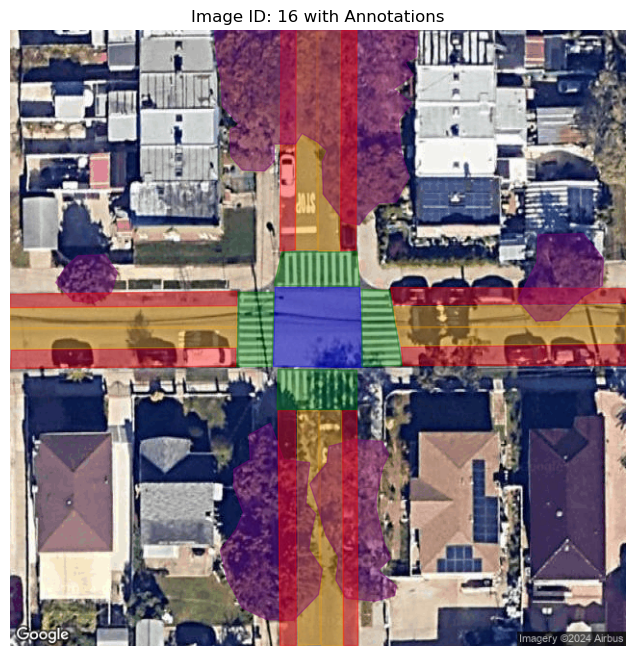

In [26]:
image_path = "../data/images"
visualize_annotations(coco, 16, image_path)

In [65]:
def visualize_annotations(image_file_path, metadata, color_map=False, plot=True):
    """
    Visualize annotations for an image using a corresponding JSON annotation file.

    :param image_file_path: Path to the image file.
    :param metadata: Metadata object containing category and color mapping.
    :param plot: Boolean flag; if True, displays the plot. If False, returns the annotated image.
    :return: Annotated image (if plot=False).
    """

    # Determine the corresponding JSON annotation file
    annotation_path = image_file_path.replace('images', 'annotations').replace(".png", ".json")

    # Load the image
    img = cv2.imread(image_file_path)

    # Load the annotations
    with open(annotation_path, "r") as f:
        annotations = json.load(f)

    # Create a Visualizer object
    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.2)

    # Generate random color map, if not provided
    if not color_map:
        color_map = {}
        for i, category in enumerate(metadata.thing_classes):
            color_map[i] = np.random.rand(3)  # Generate a random color
            
    # Overlay annotations
    for shape in annotations.get("shapes", []):
        label = shape["label"]
        points = shape["points"]
        color = color_map[metadata.thing_classes.index(label)]
        v.draw_polygon(points, color=color)
        v.draw_text(label, points[0], font_size=10)

    # Display or return the image
    if plot:
        plt.figure(figsize=(15, 10))
        plt.imshow(v.output.get_image())
        plt.axis("off")
        plt.show()
    else:
        return v.get_image()

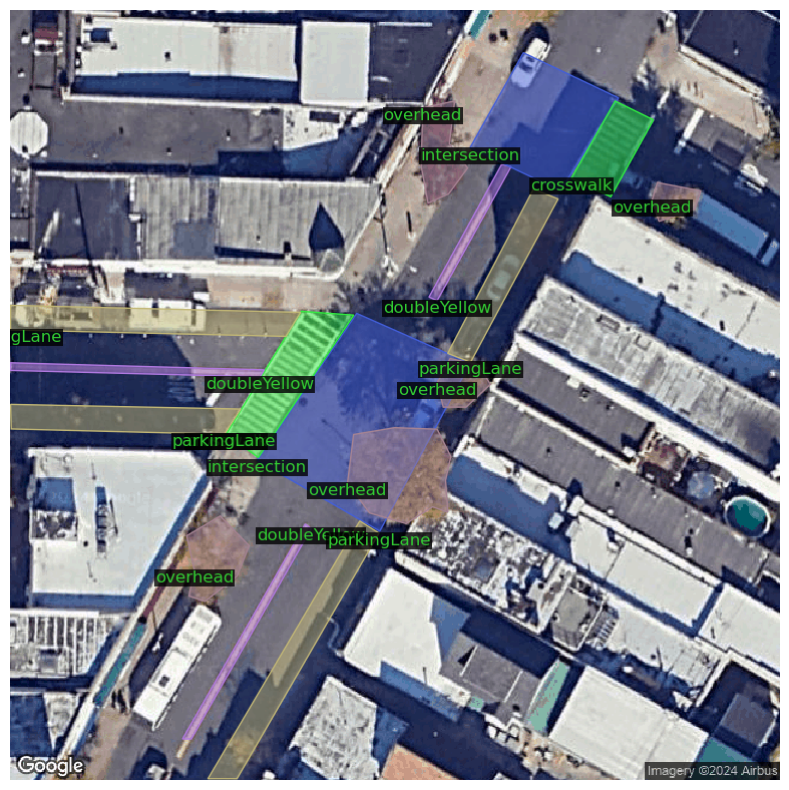

In [67]:
image_file_path = "../data/images/40.636735_-74.134282.png"
visualize_annotations(image_file_path, metadata, plot=True)

In [74]:
def visualize_annotations_with_draw_dataset(image_file_path, metadata, dataset_dicts, plot=True):
    """
    Visualize annotations using Visualizer's draw_dataset_dict for better annotation handling.

    :param image_file_path: Path to the image file.
    :param metadata: Metadata object containing class information.
    :param plot: Boolean flag; if True, displays the plot. If False, returns the annotated image.
    :return: Annotated image (if plot=False).
    """
    import os

    # Determine the corresponding JSON annotation file
    annotation_path = image_file_path.replace('images', 'annotations').replace(".png", ".json")

    # Load the image
    img = cv2.imread(image_file_path)

    # Load the annotations
    with open(annotation_path, "r") as f:
        annotations = json.load(f)

    # Prepare the dataset dictionary
    dataset_dict = [
        d for d in dataset_dicts if os.path.basename(d['file_name']) == os.path.basename(image_file_path)
    ][0]

    # Create a Visualizer
    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.2)
    v = v.draw_dataset_dict(dataset_dict)

    # Display or return the image
    if plot:
        plt.figure(figsize=(15, 10))
        plt.imshow(v.get_image())
        plt.axis("off")
        plt.show()
    else:
        return v.get_image()

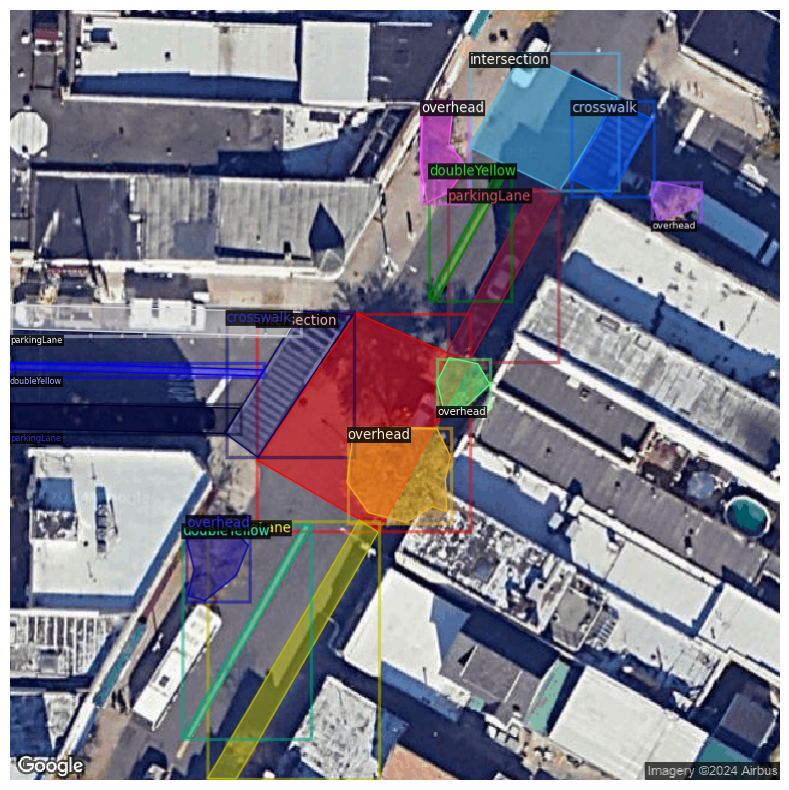

In [75]:
visualize_annotations_with_draw_dataset(image_file_path, metadata, dataset_dicts, plot=True)

# Model

In [16]:
cfg = get_cfg()

# Load base config and set model architecture
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))

# Set dataset
cfg.DATASETS.TRAIN = ("custom_train",)
cfg.DATASETS.TEST = ()  # No validation dataset for now
cfg.DATALOADER.NUM_WORKERS = 2

# Use pre-trained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")

# Training parameters for quick trial
cfg.SOLVER.IMS_PER_BATCH = 8  # Reduce batch size to fit in GPU memory
cfg.SOLVER.BASE_LR = 0.0025  # Default learning rate
cfg.SOLVER.MAX_ITER = MAX_ITER  # Fewer iterations for quick trial
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # Number of regions per image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(categories)  # Number of custom classes
cfg.MODEL.DEVICE = "cuda"

# Output directory
cfg.OUTPUT_DIR = "../models"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Train the model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

11/30/2024 16:03:40 - INFO - detectron2.engine.defaults -   Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
     

In [18]:
training_img_files = [x['file_name'] for x in coco_data['images']]

In [19]:
def visual_predictions(model_pth, img_file_path, thresold=THRESHOLD):
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_pth)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = thresold
    predictor = DefaultPredictor(cfg)

    img = cv2.imread(img_file_path)
    outputs = predictor(img)

    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(15, 10))
    plt.imshow(v.get_image())
    plt.axis("off")
    plt.show()

11/30/2024 16:27:45 - INFO - detectron2.checkpoint.detection_checkpoint -   [DetectionCheckpointer] Loading from ../models\model_final.pth ...
11/30/2024 16:27:45 - INFO - fvcore.common.checkpoint -   [Checkpointer] Loading from ../models\model_final.pth ...


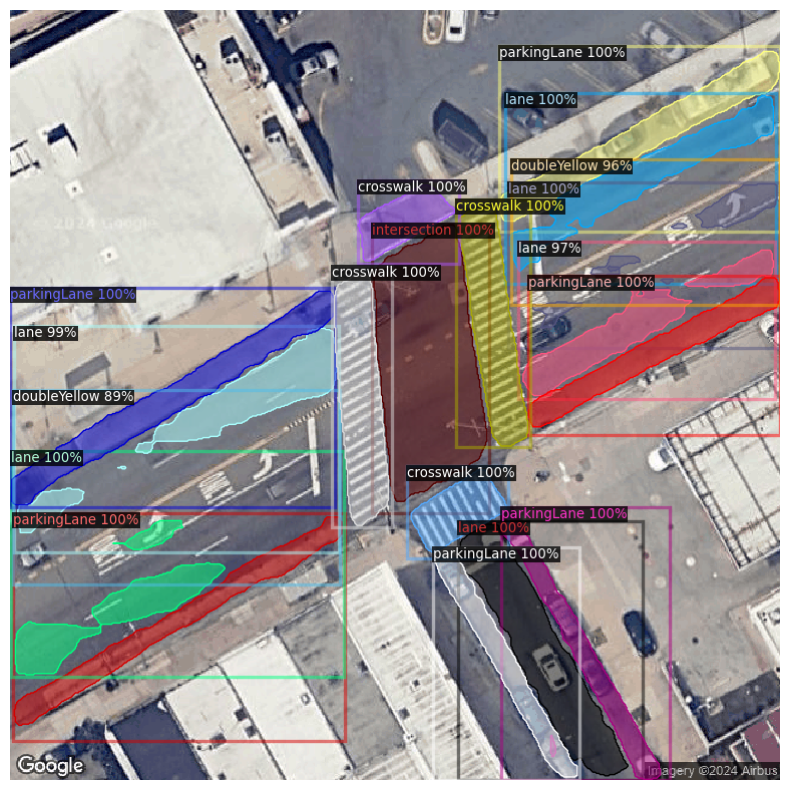

In [20]:
img_file_path = f"../data/images/{random.choice(training_img_files)}"
visual_predictions("model_final.pth", img_file_path)

# Ignore Lane Class

In [21]:
coco_data['categories']

[{'id': 0, 'name': 'lane', 'supercategory': 'lane'},
 {'id': 1, 'name': 'intersection', 'supercategory': 'intersection'},
 {'id': 2, 'name': 'crosswalk', 'supercategory': 'crosswalk'},
 {'id': 3, 'name': 'parkingLane', 'supercategory': 'parkingLane'},
 {'id': 4, 'name': 'overhead', 'supercategory': 'overhead'},
 {'id': 5, 'name': 'median', 'supercategory': 'median'},
 {'id': 6, 'name': 'doubleYellow', 'supercategory': 'doubleYellow'},
 {'id': 7, 'name': 'bikeLane', 'supercategory': 'bikeLane'},
 {'id': 8, 'name': 'laneSeparator', 'supercategory': 'laneSeparator'},
 {'id': 9, 'name': 'busLane', 'supercategory': 'busLane'}]

In [22]:
excluded_ids = [0, 9, 8]

# Filter annotations
coco_data['annotations'] = [
    ann for ann in coco_data['annotations'] if ann['category_id'] not in excluded_ids
]

# Filter categories
coco_data['categories'] = [
    cat for cat in coco_data['categories'] if cat['id'] not in excluded_ids
]

output_path = "../data/annotations/dataset.json"
with open(output_path, 'w') as f:
    json.dump(coco_data, f, indent=4)

coco_data['categories']

[{'id': 1, 'name': 'intersection', 'supercategory': 'intersection'},
 {'id': 2, 'name': 'crosswalk', 'supercategory': 'crosswalk'},
 {'id': 3, 'name': 'parkingLane', 'supercategory': 'parkingLane'},
 {'id': 4, 'name': 'overhead', 'supercategory': 'overhead'},
 {'id': 5, 'name': 'median', 'supercategory': 'median'},
 {'id': 6, 'name': 'doubleYellow', 'supercategory': 'doubleYellow'},
 {'id': 7, 'name': 'bikeLane', 'supercategory': 'bikeLane'}]

In [23]:
annotation_file = "../data/annotations/dataset.json"
register_coco_instances("clean_train", {}, annotation_file, image_path)

# Verify dataset registration
metadata = MetadataCatalog.get("clean_train")
dataset_dicts = DatasetCatalog.get("clean_train")

11/30/2024 16:27:46 - INFO - detectron2.data.datasets.coco -   Loaded 17 images in COCO format from ../data/annotations/dataset.json


In [24]:
cfg = get_cfg()

# Load base config and set model architecture
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))

# Set dataset
cfg.DATASETS.TRAIN = ("clean_train",)
cfg.DATASETS.TEST = ()  # No validation dataset for now
cfg.DATALOADER.NUM_WORKERS = 2

# Use pre-trained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")

# Training parameters for quick trial
cfg.SOLVER.IMS_PER_BATCH = 8  # Reduce batch size to fit in GPU memory
cfg.SOLVER.BASE_LR = 0.0025  # Default learning rate
cfg.SOLVER.MAX_ITER = MAX_ITER  # Fewer iterations for quick trial
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # Number of regions per image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(coco_data['categories'])  # Number of custom classes
cfg.MODEL.DEVICE = "cuda"

# Output directory
cfg.OUTPUT_DIR = "../models"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Train the model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

11/30/2024 16:27:47 - INFO - detectron2.engine.defaults -   Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
     

KeyboardInterrupt: 

11/27/2024 19:42:39 - INFO - detectron2.checkpoint.detection_checkpoint -   [DetectionCheckpointer] Loading from ../models\model_final.pth ...
11/27/2024 19:42:39 - INFO - fvcore.common.checkpoint -   [Checkpointer] Loading from ../models\model_final.pth ...


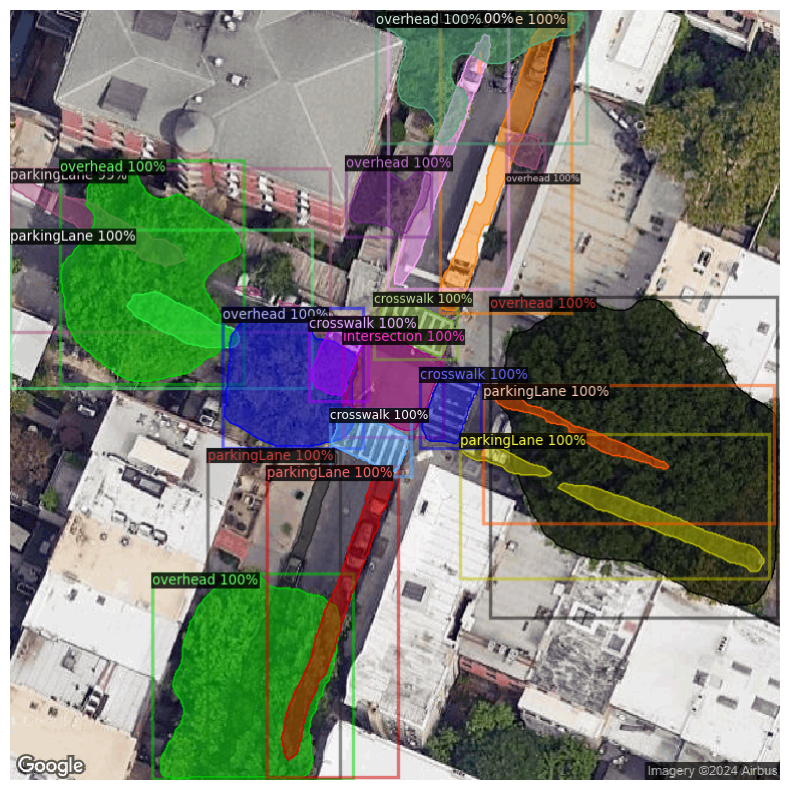

In [ ]:
img_file_path = f"../data/images/{random.choice(training_img_files)}"
visual_predictions("model_final.pth", img_file_path)

In [ ]:
img_file_path

'../data/images/40.688_-73.997562.png'

11/27/2024 19:42:41 - INFO - detectron2.checkpoint.detection_checkpoint -   [DetectionCheckpointer] Loading from ../models\model_final.pth ...
11/27/2024 19:42:41 - INFO - fvcore.common.checkpoint -   [Checkpointer] Loading from ../models\model_final.pth ...


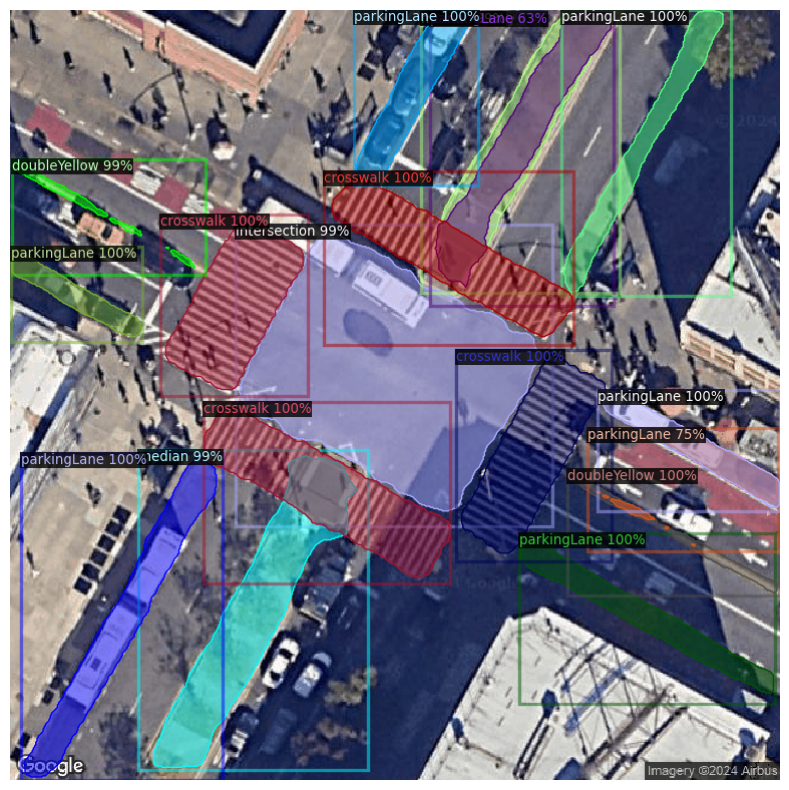

In [ ]:
img_file_path = f"../data/images/{training_img_files[15]}"
visual_predictions("model_final.pth", img_file_path)

11/27/2024 19:42:42 - INFO - detectron2.checkpoint.detection_checkpoint -   [DetectionCheckpointer] Loading from ../models\model_final.pth ...
11/27/2024 19:42:42 - INFO - fvcore.common.checkpoint -   [Checkpointer] Loading from ../models\model_final.pth ...


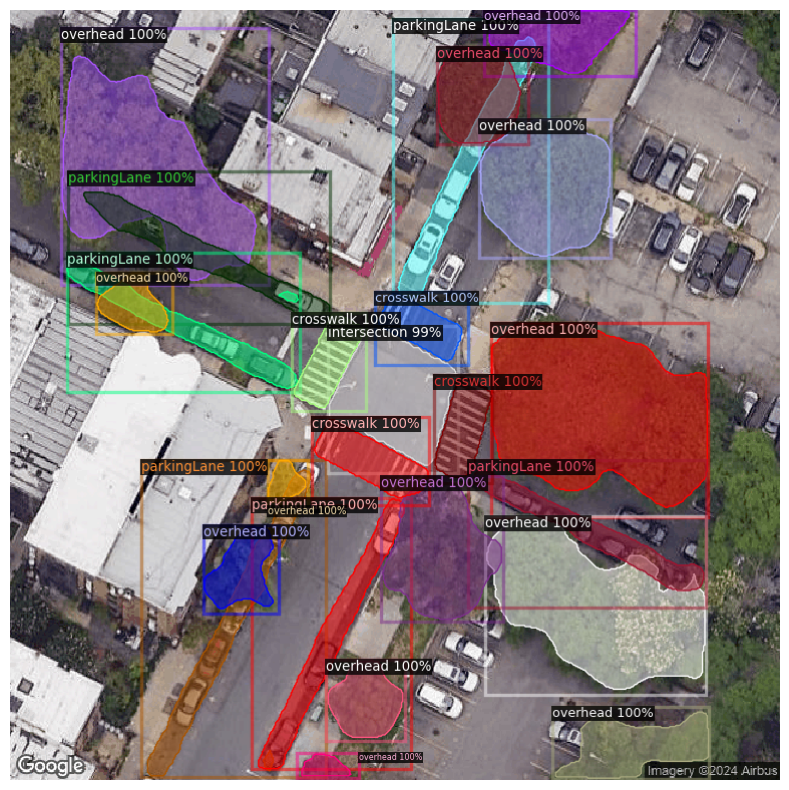

In [ ]:
img_file_path = f"../data/images/40.68355_-73.98438.png"
visual_predictions("model_final.pth", img_file_path)